# Kartéierung Schnëssen-Daten

This script is used in our Schnëssen project to draw maps for the regional distribution of language variants. For our purposes, the script has to be flexible to draw maps for a varying number of variants. During the runtime of the script the dataframes thus have to be created and modified dynamically according to the number of variants (expressed in percentages of the total amounts of all variants per location). 

The general workflow for this script:
- define some variables for the data to be used and the information to be displayed on the maps
- pull the data from the respective Google Spreadsheet
- arrange the data to the format needed for the different maps
- Option 1: Draw a single map with pie charts on the locations indicating the variant distribution (using scappterpie, inspired by https://www.brodrigues.co/blog/2018-10-27-lux_elections_analysis/)
- Option 2: Draw separate choropleth maps using ggplot2, arrange and annotate them with cowplot. The mapping is done on the commune level of Luxembourg using a continuous color scale (color palette wesanderson :-)) representing the percentage of a variant per commune. Polygon borders on the commune level are not shown in order to get a better perception of the spacial pattern of the variant. The thin polygon borders on the map present the cantons of Luxembourg.
- save the map, adjust some display features according to the number of maps on a panel, i.e. rows, cols, size.

Peter Gilles, November 2019

In [1]:
library(tidyverse)
library(magrittr)
library(scatterpie)
library(googlesheets) # soon to be repaced by googlesheets4
library(DBI)
library(tibble)
library(cellranger)
library(dplyr)
library(reshape)
library(rgeos)
library(rgdal)
library(grid)
library(gridExtra)
library(gtable)
library(wesanderson) # https://github.com/karthik/wesanderson
library(cowplot)
library(ggstatsplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths


Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:scatterpie’:

    recenter


rgeos version: 0.5-2, (SVN revision 621)
 GEOS runtime version: 3.7.2-CAPI-1.11.2 
 Linki

## Define variables for map

In [2]:
# Pad upassen un d'Struktur vum jeeweilege Computer
setwd("~/Google Drive/Schnëssen-Auswertung/R-Skripter")
# Titel fir d'Kaart
title <- "Muerten"
# Ausfëllen: name of Goolge Sheet
sheet <- "Auswertung 2"
# Ausfëllen: table name
table_name <- "11"
# Ausfëllen: range of data in table with variant data
last_row <- 1384
# Ausfëllen: name of column with variants in Google sheet
col_variants <- "Möhren"
# Ausfëllen
# 'var_' ëmmer als Prefix virdun, duerno dann déi exakt Nummer aus der Variantenkolonn
variants_to_include <- c("var_1", "var_2", "var_3", "var_4", "var_5", "var_6")
# Ausfëllen - muss exakt der Unzuel an der Reiefolleg vu 'variants_to_include' entspriechen
label <- c("Muerten", "Wuerzelen", "Muurten", "Karotten", "Morten", "Murschten")
# define colors - mir huelen d'Faarwe vum 'Fantastic Mr. Fox', méi Paletten op https://github.com/karthik/wesanderson
color <- wes_palette("FantasticFox1", length(variants_to_include), type = "continuous")

# Fonts: Fir 'Roboto' ze verwenden, muss de Font fir d'éischt lokal installéiert ginn
# https://fonts.google.com/specimen/Roboto?selection.family=Roboto

## Prepare polygons

In [3]:
# import polygon data (Origin: https://data.public.lu/en/datasets/limites-administratives-du-grand-duche-de-luxembourg/#_)
communes_shp <- readOGR("limadmin-shp/LIMADM_COMMUNES.shp")
# use the following of readOGR fails (from: https://www.brodrigues.co/blog/2018-10-27-lux_elections_analysis/)
# communes_df <- readRDS("commune_shapefile.rds")
communes_df <- fortify(communes_shp, region="COMMUNE")

# polyons for communes
communes_df <- communes_df %>%
  select(long, lat, commune = id)

# center point of commune polygon for pie chart placement
scatterpie_point <- communes_df %>%
  group_by(commune) %>%
  summarise(long = mean(long),
            lat = mean(lat))
scatterpie_point$commune <- as.factor(scatterpie_point$commune)

# polygons for cantons
cantons_shp <- readOGR("limadmin-shp/LIMADM_CANTONS.shp")
# fortify nicht nötig, ggplot2 kann nun direkt mit Shapefiles umgehen
#cantons_df <- fortify(cantons_shp, region="CANTON")

# klappt net
#rivers110 <- ne_download(scale = 10, type = 'rivers_lake_centerlines', category = 'physical')
#rivers_df <- fortify(rivers110 )

OGR data source with driver: ESRI Shapefile 
Source: "/Users/peter.gilles/Google Drive/Schnëssen-Auswertung/R-Skripter/limadmin-shp/LIMADM_COMMUNES.shp", layer: "LIMADM_COMMUNES"
with 102 features
It has 4 fields


Warning message in readOGR("limadmin-shp/LIMADM_COMMUNES.shp"):
“Z-dimension discarded”


OGR data source with driver: ESRI Shapefile 
Source: "/Users/peter.gilles/Google Drive/Schnëssen-Auswertung/R-Skripter/limadmin-shp/LIMADM_CANTONS.shp", layer: "LIMADM_CANTONS"
with 12 features
It has 2 fields


Warning message in readOGR("limadmin-shp/LIMADM_CANTONS.shp"):
“Z-dimension discarded”


## Prepare data frame for variants 

In [4]:
# for demonstration purposes, as access to the Google Spreadsheet is not possibel
# prepare some toy data
# saveRDS(input_data[1:500,], file = "input_data.rds")
# read toy data as 'input_data'
input_data <- readRDS(file = "input_data.rds")

res <- input_data[c("Gemeng_nei", col_variants)]
res <- melt(res, id=c("Gemeng_nei"))
counts <- res %>% group_by(Gemeng_nei, value) %>% count()
counts2 <- pivot_wider(counts, names_from=value, values_from = n, names_prefix = "var_")
counts2$Gemeng_nei <- as.factor(counts2$Gemeng_nei)

# col gëtt net méi gebraucht
counts2$variable <- NULL

# exclude unused cols
counts2 <- counts2[names(counts2) %in% c("Gemeng_nei", variants_to_include)]

# count for all variants per row
counts2$variant_count <- counts2 %>%
  ungroup() %>%
  select(-1) %>% 
  rowSums(na.rm = TRUE)
# save n_recordings for map
n_recordings <- sum(counts2$variant_count)
# save n_communes for map
n_communes <- nlevels(counts2$Gemeng_nei)
# percentages for all variant columns
pcts = lapply(counts2[,-1], function(x) {
  x / counts2$variant_count
})
pcts = as.data.frame(pcts)
pcts$variant_count <- NULL
# rename these newly created columns as they would be identical to the variant count columns
colnames(pcts) <- paste0(colnames(pcts), "_percent")

# get the colnames used for mapping
variant_names_percentages <- colnames(pcts)
# bind counts + percentages together
counts3 <- bind_cols(counts2, pcts)
# generates also a column for total count, remove it
#counts3$variant_count <- NULL
# convert all NAs to 0
counts3[is.na(counts3)] <- 0

# create dataframe for pie charts map
final_data <- left_join(scatterpie_point, counts3, by = c("commune"= "Gemeng_nei"))

Warning message:
“Factor `Gemeng_nei` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message in `[<-.factor`(`*tmp*`, thisvar, value = 0):
“invalid factor level, NA generated”
Warning message:
“Column `commune`/`Gemeng_nei` joining factors with different levels, coercing to character vector”


# Draw pie chart map

Warning message:
“Removed 54 rows containing non-finite values (stat_pie).”


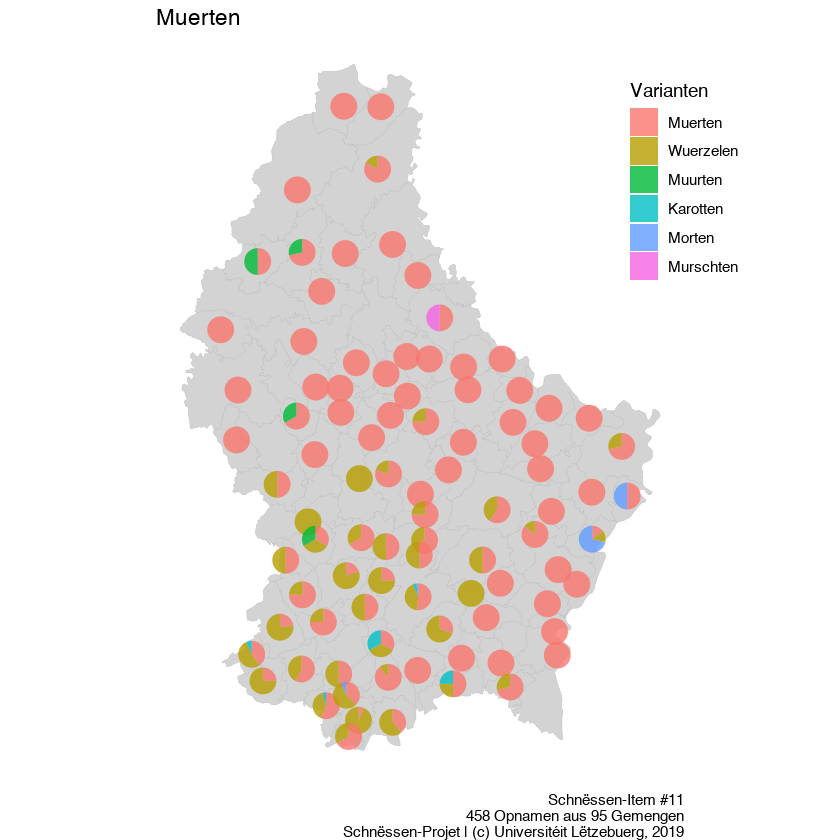

In [5]:
ggplot() +
  geom_polygon(data = communes_df, aes(x = long, y = lat, group = commune), 
               size=.1, colour = "grey", fill = "lightgrey") +
  geom_scatterpie(data=final_data, 
                  aes(x=long, y=lat, group=commune, r=1600), 
                  color=NA, alpha=.8,
                  cols= variant_names_percentages)   + coord_fixed() +
  labs(title = title) +
  theme_void() +
  theme(legend.position = c(1, 0.8),
        plot.background = element_rect("white")) +
  scale_fill_discrete(labels = label) +
  labs(fill = "Varianten") +
  labs(caption = paste0("Schnëssen-Item #", table_name, "\n", n_recordings, " Opnamen aus ", n_communes, " Gemengen", "\nSchnëssen-Projet | (c) Universitéit Lëtzebuerg, 2019"))


# Draw separate choropleth maps

Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



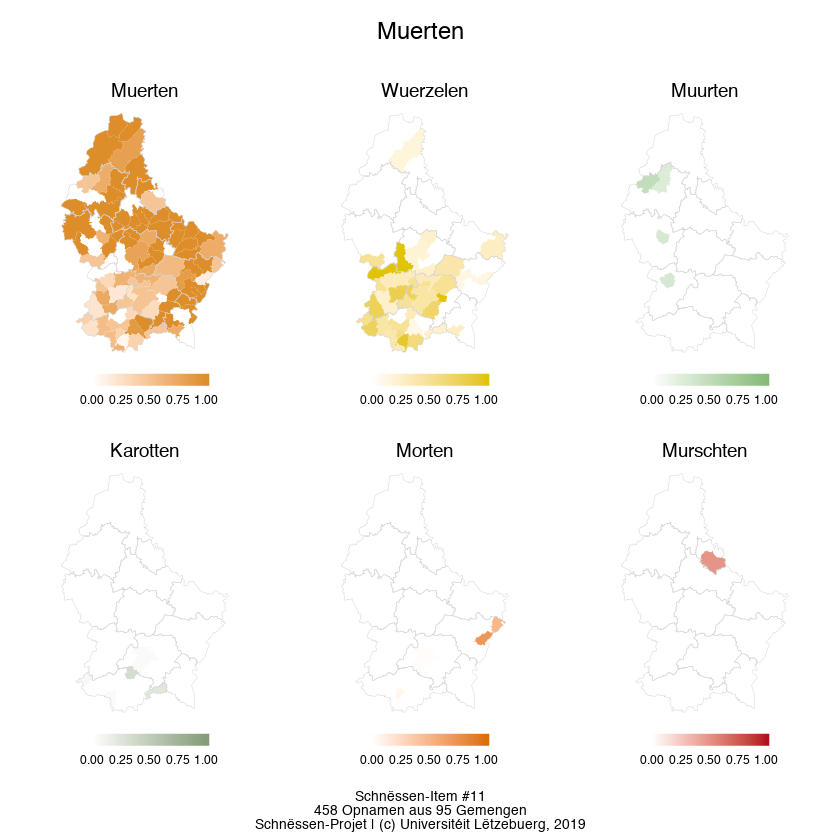

In [7]:
### prepare new data set ###
df_new <- merge(communes_df, final_data, by="commune", all.x=T, all.y=T, sort=F)

# draw as many maps as there are selected variants and arrange them
# contains three lists for label, color and percentage of variant
input_map <- list(label, color, paste0(variants_to_include, "_percent"))

# single maps will be stored in this list
plot_list = list()
# loop through the creation of maps, various arguments are transfered from input_map
for (i in 1:length(input_map[[1]])) {
  p = ggplot() +
    geom_polygon(data = df_new, aes_string(x = "long.x", y = "lat.x", fill=input_map[[3]][i], 
                                group = "commune"), size=0, colour = "lightgrey") +
    geom_polygon(data = cantons_shp, aes(x = long, y = lat, group = group), 
                 size= .1, colour = "lightgrey", fill = NA) +
    coord_fixed() +
    scale_fill_gradient(low = "white", high = input_map[[2]][i], name = input_map[[1]][i], na.value="white", limits=0:1) +
    labs(title = input_map[[1]][i], x = "", y = "") +
    theme_void() +
    theme(plot.title = element_text(size=11, hjust = 0.5),
          legend.position = "bottom", # c(0.85, 0.75)
          legend.text = element_text(size=7),
          legend.title = element_blank(),
          plot.margin=unit(c(0.3,0,0.3,0.2), "cm")) +
    guides(fill = guide_colourbar(barwidth = 5, barheight = .5, ticks = FALSE))
  map_name <- paste0("map_", i)
  assign(map_name, p)
  #plot_list[[i]] = as.grob(p)
}

# prepare list with names for (temporary) single map objects
maps_to_draw <- c(paste0("map_", seq(1:length(label))))

# arrange all maps in one grid
# takes some time
plot_row <- plot_grid(plotlist=mget(maps_to_draw))

# prepare the caption for map panel dynamically
caption <- paste0(
  "Schnëssen-Item #", table_name,
  "\n", n_recordings, " Opnamen aus ", n_communes, " Gemengen", "\nSchnëssen-Projet | (c) Universitéit Lëtzebuerg, 2019")

# display the combined map panel with title and caption
combine_plots(plot_list=plot_row, 
              ncol = 1,
              title.text = title,
              title.size = 14,
              caption.text = caption,
              caption.size = 8
              )

# delete remporary maps
rm(list=ls(pattern="map_"))